In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import numpy as np

from sklearn.model_selection import train_test_split
from math import log2, ceil

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleAverage, LinearRegressionDecider
from proglearn.transformers import TreeRegressionTransformer
from proglearn.voters import TreeRegressionVoter
from joblib import Parallel, delayed

C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\shizh\Anaconda3\envs\proglearn\lib\site-packages\ten

In [2]:
def generateGaussians(sample_size, corr):
    mean = [0, 0]
    cov = [[1, corr], [corr, 1]]
    return np.random.multivariate_normal(mean, cov, sample_size)

In [3]:
def makeOutput(x):
#     sigma=1
#     return (1/(2*np.pi*sigma*sigma))*np.exp(- (x[:,0]*x[:,0] + x[:,1]*x[:,1])/(2*sigma*sigma))
#     return np.sum(np.abs(x)**2,axis=-1)**(1./2)
    return np.sum(np.abs(x), axis=1)

In [4]:
def plot_distributions(x,z, title):
    colors = sns.color_palette("Dark2", n_colors=2)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].scatter(x[:,0], x[:,1], s=50)
    ax[1].scatter(z[:,0], z[:,1], s=50)
    ax[0].set_title(title[0], fontsize=30)
    ax[1].set_title(title[1], fontsize=30)

    plt.tight_layout()
    plt.show()

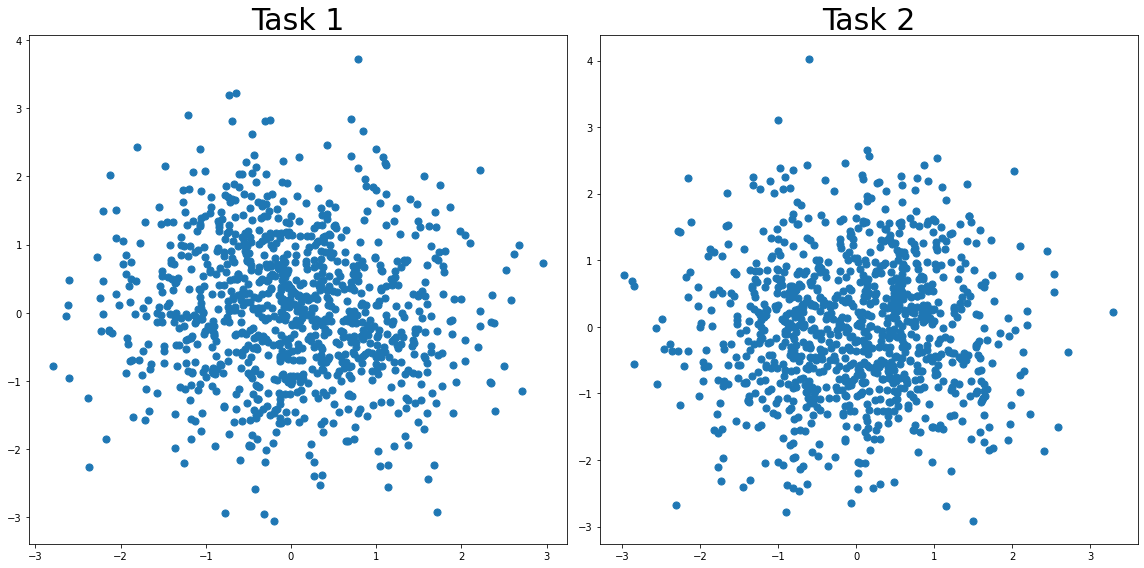

In [5]:
X1 = generateGaussians((1000), 0)
X2 = generateGaussians((1000), 0)

# plot and format:
plot_distributions(X1, X2, ['Task 1', 'Task 2'])

Text(0.5, 0.92, 'Task 2: L1 distance')

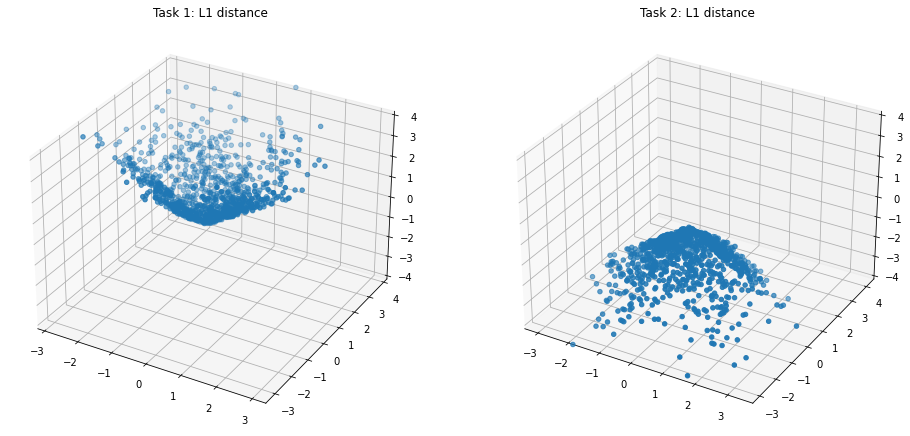

In [6]:
fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(1,2,1,projection='3d')
Z1 = makeOutput(X1)
ax1.scatter3D(X1[:,0],X1[:,1], Z1)
ax1.set_zlim([-4,4])
ax1.set_title('Task 1: L1 distance')

Z2 = makeOutput(X2)
Z2 = -Z2
ax2 = fig.add_subplot(1,2,2,projection='3d')
ax2.scatter3D(X2[:,0],X2[:,1], Z2)
ax2.set_zlim([-4,4])
ax2.set_title('Task 2: L1 distance')

In [7]:
def experiment(n_pos, n_neg, n_test, n_trees, max_depth=None, acorn=None):
    
    # See if the sample sizes for both training sets,
    # y=x and y=-x have been given.
    if n_pos == 0 and n_neg == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, we need two errors,
    # one for task 1 (y=x) and one for task 2 (y=-x)
    errors = np.zeros(2, dtype=float)
    
    # Initialize the transformer type and arguments
    default_transformer_class = TreeRegressionTransformer
    if (max_depth == None):
        default_transformer_kwargs = {}
    else:
        default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    
    # Initialize the voter type and arguments
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}
    
    # Initialize the decider type and arguments
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}
    
    # Initialize the progressive learner using the transformer, voter,
    # and decider classes
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets for the linear expressions and their test sets
    if (n_pos != 0):
        X1 = generateGaussians(n_pos, 0)
        Z1 = makeOutput(X1)
        X1_test = generateGaussians(n_test, 0)
        Z1_test = makeOutput(X1_test)
        
    if (n_neg != 0):
        X2 = generateGaussians(n_neg, 0)
        Z2 = makeOutput(X2)
        X2_test = generateGaussians(n_test, 0)
        Z2_test = makeOutput(X2_test)
    
    #####################################################################
    # Start training and predicting with the progressive learner
    #####################################################################
    # If there is no sample size for y=x, then only add a task for y=-x, predict
    # the probabilities and add the errors to the error array
    if (n_pos == 0 and n_neg != 0):
        # Add task to progressive learner
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)

        errors[0] = 1.0
        errors[1] = mean_squared_error(predicted_Z2, Z2_test)
    
    # If there is no sample size for y=-x, then only add a task for y=x, predict
    # the probabilities and add the errors to the error array
    elif (n_neg == 0 and n_pos != 0):
        # Add task to progressive learner
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)

        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        errors[1] = 1.0
    
    # If both sample sizes are given, add a task for the first dataset, predict
    # the probabilities and add the errors to the error array. Then, add the
    # transformer trained on y=-x and predict the error from there.
    elif (n_neg != 0 and n_pos != 0):
        # Add tasks to progressive learner
        progressive_learner.add_task(X1, Z1)
        predicted_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z1, Z1_test)
        
        progressive_learner.add_transformer(X2, Z2,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z1 = progressive_learner.predict_proba(X1_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z1, Z1_test)
        
    return errors

In [8]:
# Set up the tree parameters
mc_rep = 1000
n_test = 1000
n_trees = 10
n_sample_size = 1000
max_depth = None

# Sample sizes for y=x and y=-x
n_pos = (100*np.arange(0.5, 7.75, step=0.50)).astype(int)
n_neg = (100*np.arange(0.5, 7.75, step=0.50)).astype(int)

In [9]:
# Initiate error arrays
mean_error = np.zeros((2, len(n_pos) + len(n_neg)))
std_error = np.zeros((2, len(n_pos) + len(n_neg)))

# Initiate transfer efficiency arrays
mean_te = np.zeros((1, len(n_pos) + len(n_neg)))
std_te = np.zeros((1, len(n_pos) + len(n_neg)))

#####################################################################
# Iterate over the sample sizes.
#####################################################################
# Start with only task 1 (y=x) dataset and calculate the mean squared error 
# for only one task. Then, when we reach the end of the sample size for y=x,
# we use the maximum sample size for task 1 and see how BTE and FTE change 
# when we iterate over the sample size for task 2 (y=-x). 
for i, n1 in enumerate(n_pos):
    print('starting to compute y=x, sample size=%s\n' %n1)
    error = np.array(
        Parallel(n_jobs=-1, verbose=1)(
            delayed(experiment)(
                n1, 0, n_test, n_trees, max_depth) for _ in range(mc_rep)
            )
        )
    mean_error[:,i] = np.mean(error,axis=0)
    std_error[:,i] = np.std(error,ddof=1,axis=0)
    mean_te[0,i] = np.mean(error[:,0]/error[:,1])
    std_te[0,i] = np.std(error[:,0]/error[:,1],ddof=1)
    
    if n1==n_pos[-1]:
        for j,n2 in enumerate(n_neg):
            print('starting to compute y=-x, sample size=%s\n'%n2)
            error = np.array(
                Parallel(n_jobs=-1,verbose=1)(
                    delayed(experiment)(n1,n2,n_test,n_trees, max_depth) for _ in range(mc_rep)
                )
            )
            # extract relevant data and store in arrays
            mean_error[:,i+j+1] = np.mean(error,axis=0)
            std_error[:,i+j+1] = np.std(error,ddof=1,axis=0)
            mean_te[0,i+j+1] = np.mean(error[:,0]/error[:,1])
            std_te[0,i+j+1] = np.std(error[:,0]/error[:,1],ddof=1)

mean_bte = mean_te

starting to compute y=x, sample size=50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=100



[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=150



[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    3.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=200



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=250



[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    4.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=300



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=350



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=400



[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=450



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=500



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=550



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=600



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=650



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=700



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=x, sample size=750



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=50



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=100



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   15.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=150



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=200



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=250



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=300



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=350



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=400



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=450



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=500



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=550



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=600



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   22.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=650



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=700



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=750



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.2s finished


No handles with labels found to put in legend.


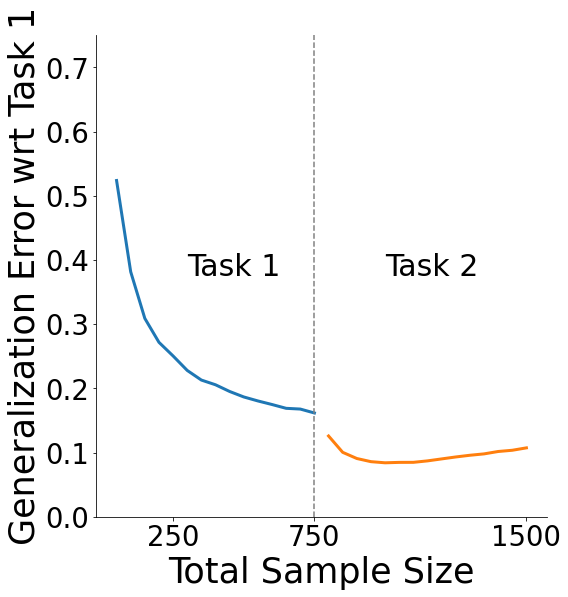

In [10]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
y1_vals = mean_error[0]
y2_vals = mean_error[1]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(n_pos, mean_error[0][0:len(n_pos)], ls="-", lw=3)
ax1.plot(n_neg + n_pos[-1], mean_error[1][len(n_pos):], ls="-", lw=3)

ax1.set_ylabel("Generalization Error wrt Task 1", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
ax1.set_ylim([0, 0.75])
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

In [11]:
print(mean_error)

[[0.52392161 0.38173131 0.30909197 0.27182475 0.25056684 0.22803263
  0.21303984 0.20570136 0.19525833 0.18672832 0.18050414 0.17493119
  0.16899661 0.16785867 0.16173196 0.16346365 0.16284833 0.16375802
  0.16258494 0.1617648  0.16353385 0.1613474  0.16233872 0.16356657
  0.16419604 0.16314582 0.16142109 0.16456046 0.16203358 0.16209767]
 [1.         1.         1.         1.         1.         1.
  1.         1.         1.         1.         1.         1.
  1.         1.         1.         0.12591464 0.10045938 0.09082707
  0.08590411 0.08413868 0.08477923 0.08485114 0.08712169 0.09018311
  0.09322395 0.09586776 0.09800857 0.10173841 0.10365649 0.10739122]]


No handles with labels found to put in legend.


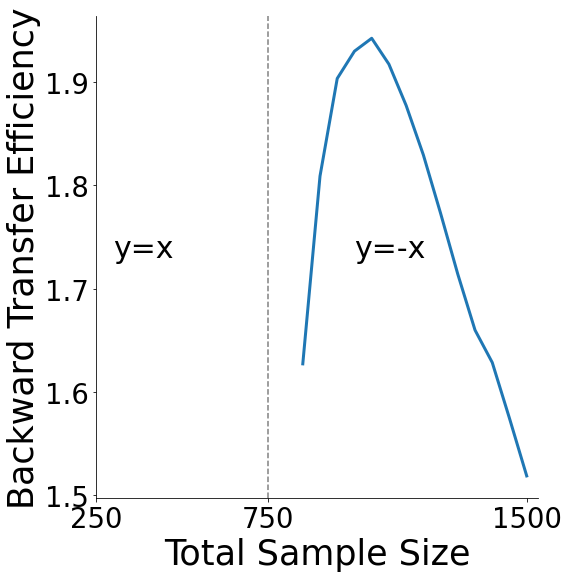

In [12]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
y1_vals = mean_te[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals[len(n_pos)+1:], y1_vals[len(n_pos)+1:], ls="-", lw=3)

ax1.set_ylabel("Backward Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

In [13]:
def experiment(n_pos, n_neg, n_test, n_trees, max_depth, acorn=None):
    
    # See if the sample sizes for both training sets,
    # y=x and y=-x have been given.
    if n_pos == 0 and n_neg == 0:
        raise ValueError("Wake up and provide samples to train!!!")

    # If acorn is specified, set random seed to it
    if acorn != None:
        np.random.seed(acorn)

    # Initialize array for storing errors, we need two errors,
    # one for task 1 (y=x) and one for task 2 (y=-x)
    errors = np.zeros(2, dtype=float)
    
    # Initialize the transformer type and arguments
    default_transformer_class = TreeRegressionTransformer
    if (max_depth == None):
        default_transformer_kwargs = {}
    else:
        default_transformer_kwargs = {"kwargs": {"max_depth": max_depth}}
    
    # Initialize the voter type and arguments
    default_voter_class = TreeRegressionVoter
    default_voter_kwargs = {}
    
    # Initialize the decider type and arguments
    default_decider_class = SimpleAverage
    default_decider_kwargs = {}
    
    # Initialize the progressive learner using the transformer, voter,
    # and decider classes
    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class, 
                                             default_transformer_kwargs = default_transformer_kwargs,
                                             default_voter_class = default_voter_class,
                                             default_voter_kwargs = default_voter_kwargs,
                                             default_decider_class = default_decider_class,
                                             default_decider_kwargs = default_decider_kwargs)
    
    # Create the datasets for the linear expressions and their test sets
    if (n_pos != 0):
        X1 = generateGaussians(n_pos, 0)
        Z1 = makeOutput(X1)
        X1_test = generateGaussians(n_test, 0)
        Z1_test = makeOutput(X1_test)
        
    if (n_neg != 0):
        X2 = generateGaussians(n_neg, 0)
        Z2 = makeOutput(X2)
        X2_test = generateGaussians(n_test, 0)
        Z2_test = makeOutput(X2_test)
    
    #####################################################################
    # Start training and predicting with the progressive learner
    #####################################################################     
    # If both sample sizes are given, add a task for the first dataset, predict
    # the probabilities and add the errors to the error array. Then, add the
    # transformer trained on y=-x and predict the error from there.
    if (n_neg != 0 and n_pos != 0):
        # Add tasks to progressive learner
        progressive_learner.add_task(X2, Z2)
        predicted_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[0] = mean_squared_error(predicted_Z2, Z2_test)
        
        progressive_learner.add_transformer(X1, Z1,
                                            transformer_class=default_transformer_class,
                                            transformer_kwargs=default_transformer_kwargs,
                                            voter_class=default_voter_class,
                                            voter_kwargs=default_voter_kwargs,
                                            transformer_id=1
                                           )
        predicted_transformer_Z2 = progressive_learner.predict_proba(X2_test, task_id=0)
        errors[1] = mean_squared_error(predicted_transformer_Z2, Z2_test)
        
    return errors

In [14]:
# Initiate error arrays
mean_error = np.zeros((2, len(n_neg)))
std_error = np.zeros((2, len(n_neg)))

# Initiate transfer efficiency arrays
mean_te = np.zeros((1, len(n_neg)))
std_te = np.zeros((1, len(n_neg)))

#####################################################################
# Iterate over the sample sizes.
#####################################################################
# Start with only task 1 (y=x) dataset and calculate the mean squared error 
# for only one task. Then, when we reach the end of the sample size for y=x,
# we use the maximum sample size for task 1 and see how BTE and FTE change 
# when we iterate over the sample size for task 2 (y=-x).

for j,n2 in enumerate(n_neg):
    print('starting to compute y=-x, sample size=%s\n'%n2)
    error = np.array(
        Parallel(n_jobs=-1,verbose=1)(
            delayed(experiment)(750,n2,n_test,n_trees, max_depth) for _ in range(mc_rep)
        )
    )
    # extract relevant data and store in arrays
    mean_error[:,j] = np.mean(error,axis=0)
    std_error[:,j] = np.std(error,ddof=1,axis=0)
    mean_te[0,j] = np.mean(error[:,0]/error[:,1])
    std_te[0,j] = np.std(error[:,0]/error[:,1],ddof=1)

mean_fte = mean_te

starting to compute y=-x, sample size=50



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=100



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    8.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=150



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   10.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=200



[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 728 tasks      | elapsed:    8.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   11.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=250



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   14.2s


starting to compute y=-x, sample size=300



[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   16.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=350



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=400



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=450



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   18.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=500



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   19.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=550



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   20.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=600



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=650



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   23.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=700



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   28.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


starting to compute y=-x, sample size=750



[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.8s finished


No handles with labels found to put in legend.


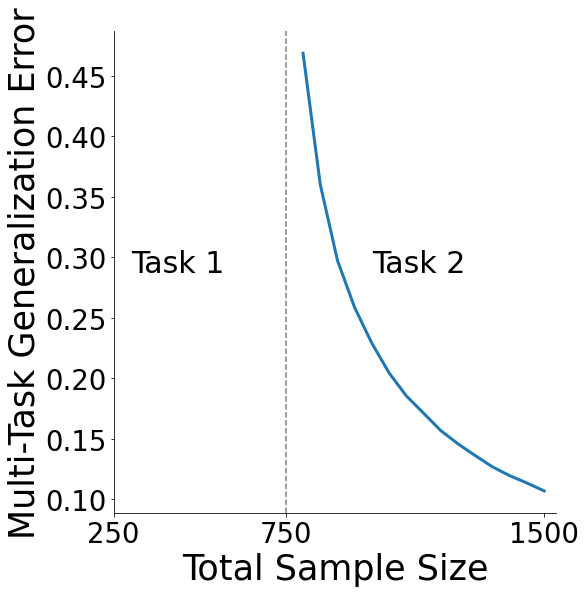

In [15]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

x_vals = n_neg + n_pos[-1]
y1_vals = mean_error[1]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Multi-Task Generalization Error", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

No handles with labels found to put in legend.


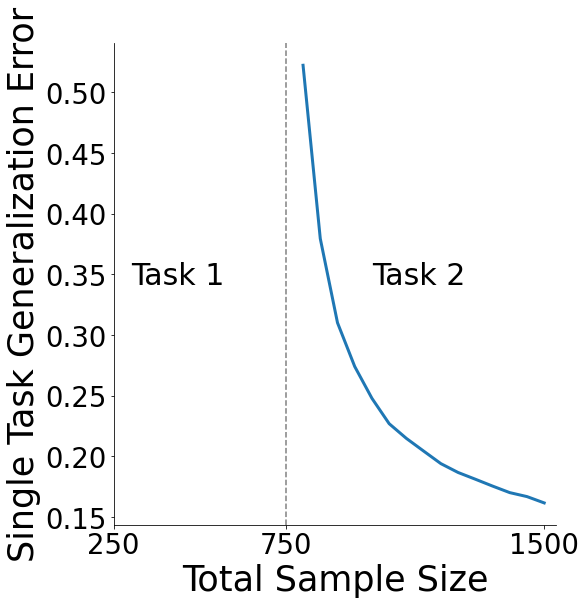

In [16]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

x_vals = n_neg + n_pos[-1]
y1_vals = mean_error[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Single Task Generalization Error", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

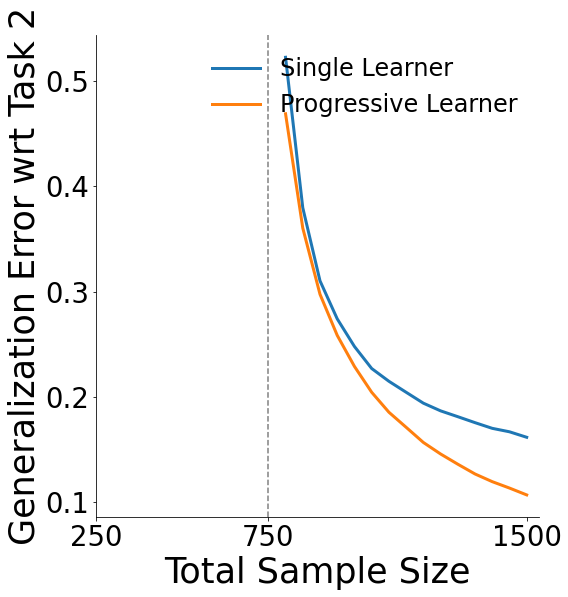

In [17]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

label=['Single Learner', 'Progressive Learner']

x_vals = n_neg + n_pos[-1]
y1_vals = mean_error[0]
y2_vals = mean_error[1]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.plot(x_vals, y1_vals, ls="-", lw=3)
ax.plot(x_vals, y2_vals, ls="-", lw=3)

ax.set_ylabel("Generalization Error wrt Task 2", fontsize=35)

ax.legend(label, loc="upper right", fontsize=24, frameon=False)
ax.set_xlabel("Total Sample Size", fontsize=35)

ax.tick_params(labelsize=27.5)
ax.set_xticks([250, 750, 1500])

ax.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")

right_side = ax.spines["right"]

right_side.set_visible(False)
top_side = ax.spines["top"]

top_side.set_visible(False)
# ax.text(300, np.mean(ax.get_ylim()), "%s"%(TASK1), fontsize=30)
# ax.text(1000, np.mean(ax.get_ylim()), "%s"%(TASK2), fontsize=30)

plt.tight_layout()

No handles with labels found to put in legend.


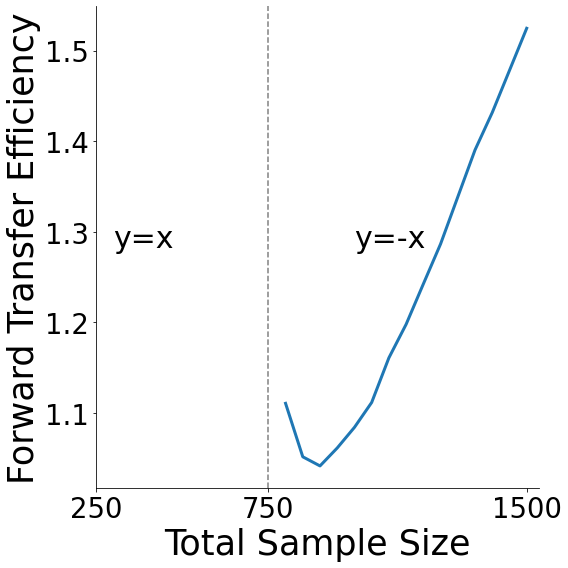

In [18]:
# define labels
TASK1 = "y=x"
TASK2 = "y=-x"

x_vals = n_neg + n_pos[-1]
y1_vals = mean_te[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(x_vals, y1_vals, ls="-", lw=3)

ax1.set_ylabel("Forward Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()

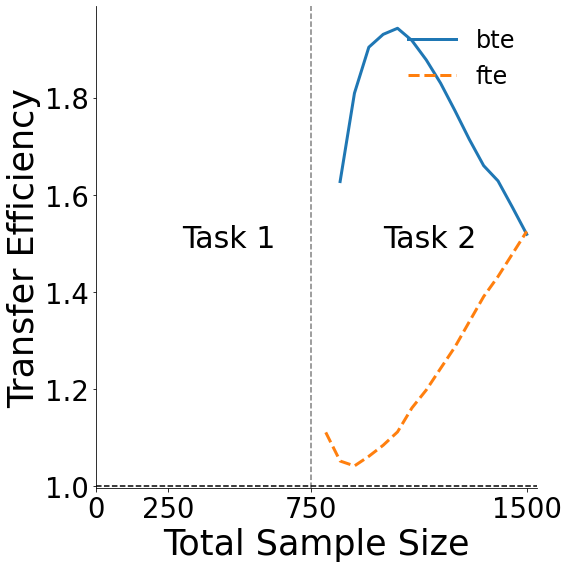

In [19]:
# define labels
TASK1 = "Task 1"
TASK2 = "Task 2"

# x_vals = np.concatenate((n_pos, n_neg + n_pos[-1]))
# x_vals = n_neg + n_pos[-1]

y1_vals = mean_bte[0]
y2_vals = mean_fte[0]

fig1 = plt.figure(figsize=(8, 8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.plot(np.concatenate((n_pos, n_neg + n_pos[-1]))[len(n_pos)+1:], y1_vals[len(n_pos)+1:], ls="-", lw=3, label="bte")

ax1.plot((n_neg + n_pos[-1]), y2_vals, ls="dashed", lw=3, label="fte")

ax1.set_ylabel("Transfer Efficiency", fontsize=35)
ax1.legend(loc="upper right", fontsize=24, frameon=False)
ax1.set_xlabel("Total Sample Size", fontsize=35)
ax1.tick_params(labelsize=27.5)
ax1.set_xticks([0, 250, 750, 1500])
ax1.axvline(x=750, c="gray", linewidth=1.5, linestyle="dashed")
ax1.axhline(y=1.0, c="black", linewidth=1.5, linestyle="dashed")
right_side = ax1.spines["right"]
right_side.set_visible(False)
top_side = ax1.spines["top"]
top_side.set_visible(False)
ax1.text(300, np.mean(ax1.get_ylim()), "%s"%(TASK1), fontsize=30)
ax1.text(1000, np.mean(ax1.get_ylim()), "%s"%(TASK2), fontsize=30)
plt.tight_layout()